In [1]:
%matplotlib inline
import os
import warnings

import critical_loads as cl
import gdal
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rasterio
import rasterio.plot
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.simplefilter("ignore")
plt.style.use("ggplot")

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


# Exceedances of critical loads for water using bias-corrected EMEP data

Kari needs to calculate exceedances of critical loads for water using bias-corrceted EMEP data for the 2020s and 2030s (see e-mail received 23.09.2020 at 08.53 for details). 

## 1. Deposition

The code below illustrates how to use the new CL functions to estimate 2020 and 2030 deposition of N and S for Norway using the **delta-change** method (see the issue [here](https://github.com/JamesSample/critical_loads_2/issues/4)) for details.

Change factors are calculated by comparing EMEP data for 2015 and 2020/2030, and these are then applied to the NILU dataset for 2012 - 2016. The output grids are saved e.g. here

    /home/jovyan/shared/critical_loads/raster/deposition/ndep_mgpm2pyr_pred2030_120m.tif

In [3]:
# Show series in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)
    display(ser_grid)

,series_id,name,short_name,grid,description
0,1,Middel 1978-1982,7882,blr,Fordelt til BLR av NILU 2002
1,2,Middel 1992-1996,9296,blr,Fordelt til BLR av NILU 2002
2,3,Middel 1997-2001,9701,blr,Fordelt til BLR av NILU 2002
3,4,Middel 2002-2006,0206,blr,Fordelt til BLR av NILU 2008 (Wenche Aas)
4,5,Beregnet 2010,None,None,"Gøteborg protokollen 1999. ""Gamle"""
...,...,...,...,...,...
60,61,EMEP 1995 b,emep1995b,emep,"1995 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
61,62,EMEP 2000 b,emep2000b,emep,"2000 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
62,63,EMEP 2005 b,emep2005b,emep,"2005 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"
63,64,EMEP 2010 b,emep2010b,emep,"2010 data based on the EMEP 0.50x0.25 degree grid. 3 vegetation classes. Extracted by Max Posch, received Oct 2020"


NILU 2012 - 2016 is series ID 28; EMEP 2015 is series ID 65 (named `emep2015b` in the database and supplied by Max in October 2020); EMEP 2020 and 2030 have series IDs 58 and 59, respectively.

In [4]:
# Export rasters of interest in mg/m2/yr
series_ids = [28, 65, 58, 59]
cell_size = 120
unit = "mgpm2pyr"
pars = ["nitrogen", "sulphur"]

for par in pars:
    for series_id in series_ids:
        cl.create_deposition_raster(
            series_id,
            par,
            unit,
            cell_size,
            eng,
            ndv=-1,
            veg_class="grid average",
        )

The code below applies the delta-change method. It's a little more complicated than strictly necessary, as each dataset is processed in blocks to keep memory consumption low. An alternative would be to simply sign-in on a more powerful machine, in which case the `block` loop below could be removed.

In [5]:
# Output location
data_fold = r"/home/jovyan/shared/critical_loads/raster/deposition"

# Loop over data
for par in pars:
    for year in [2020, 2030]:
        # Paths
        nilu_hist_path = os.path.join(data_fold, f"{par[0]}dep_mgpm2pyr_1216_120m.tif")
        emep_hist_path = os.path.join(
            data_fold, f"{par[0]}dep_mgpm2pyr_emep2015b_120m.tif"
        )
        emep_fut_path = os.path.join(
            data_fold, f"{par[0]}dep_mgpm2pyr_emep{year}_120m.tif"
        )

        # Datasets
        nilu_hist_src = rasterio.open(nilu_hist_path)
        emep_hist_src = rasterio.open(emep_hist_path)
        emep_fut_src = rasterio.open(emep_fut_path)

        # Create output dataset
        prof = nilu_hist_src.profile
        out_tif = os.path.join(data_fold, f"{par[0]}dep_mgpm2pyr_bcpred{year}_120m.tif")
        out_dst = rasterio.open(out_tif, "w", **prof)

        # Process in blocks to conserve memory
        for block_index, window in nilu_hist_src.block_windows(1):
            # Read block
            nilu_hist_block = nilu_hist_src.read(window=window).astype(float)
            emep_hist_block = emep_hist_src.read(window=window).astype(float)
            emep_fut_block = emep_fut_src.read(window=window).astype(float)

            # Set NoData to NaN
            nilu_hist_block[nilu_hist_block == -1] = np.nan
            emep_hist_block[emep_hist_block == -1] = np.nan
            emep_fut_block[emep_fut_block == -1] = np.nan

            # Apply delta-change method
            pred_block = nilu_hist_block * emep_fut_block / emep_hist_block

            # Set NaN to -1
            pred_block = np.nan_to_num(pred_block, nan=-1)

            out_dst.write(pred_block.astype(rasterio.int16), window=window)

        # Tidy up
        nilu_hist_src.close()
        emep_hist_src.close()
        emep_fut_src.close()
        out_dst.close()

## 2. Exceedances of critical loads for water

Modify the options below to match the decade of interest. 

In [6]:
# Series ID. Use '58bc' for 2020s; '59bc' for 2030s.
# Note that these are not 'real' series IDs in the db, but can be used here
# as an identifier here nevertheless
series_ids = ["58bc", "59bc"]

# Short name used in deposition grid for decade of interest
short_names = ["bcpred2020", "bcpred2030"]

cell_size = 120
base_path = r"/home/jovyan/shared/critical_loads/raster"

### 2.1. SSWC model

In [7]:
for idx, series_id in enumerate(series_ids):
    ex_df = cl.calculate_water_exceedance_sswc(
        series_id, short_names[idx], cell_size=120
    )

    print(f"\nSSWC exceedance for {short_names[idx]}:")
    print(ex_df)
    print("\n\n")

Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/sswc_ex_meqpm2pyr_bcpred2020_120m.tif

SSWC exceedance for bcpred2020:
  series_id      medium  total_area_km2  exceeded_area_km2  exceeded_area_pct
0      58bc  water_sswc          322171              15120                  5



Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/sswc_ex_meqpm2pyr_bcpred2030_120m.tif

SSWC exceedance for bcpred2030:
  series_id      medium  total_area_km2  exceeded_area_km2  exceeded_area_pct
0      59bc  water_sswc          322171              13642                  4





### FAB model

In [8]:
# Read CL arrays
array_dict = {}
for par in [
    "clminn_meqpm2pyr",
    "clmaxnoaa_meqpm2pyr",
    "clmins_meqpm2pyr",
    "clmaxsoaa_meqpm2pyr",
]:
    # Read tif
    tif_path = os.path.join(base_path, "water", f"{par}_{cell_size}m.tif")
    data, ndv, epsg, extent = nivapy.spatial.read_raster(tif_path)

    # Set NDV
    data[data == ndv] = np.nan

    # Add to dict
    array_dict[par] = data

# Read dep arrays
for par in ["ndep_mgpm2pyr", "sdep_mgpm2pyr"]:
    for short_name in short_names:
        # Read tif
        tif_path = os.path.join(
            base_path, "deposition", f"{par}_{short_name}_{cell_size}m.tif"
        )
        data, ndv, epsg, extent = nivapy.spatial.read_raster(tif_path)
        data = data.astype(np.float32)

        # Set NDV
        data[data == ndv] = np.nan

        # Add to dict
        array_dict[(short_name, par)] = data

In [9]:
%%time

# Snap tiff
snap_tif = f"/home/jovyan/shared/critical_loads/raster/blr_land_mask_{cell_size}m.tif"

# Extract arrays from dict
cln_min = array_dict["clminn_meqpm2pyr"]
cln_max = array_dict["clmaxnoaa_meqpm2pyr"]
cls_min = array_dict["clmins_meqpm2pyr"]
cls_max = array_dict["clmaxsoaa_meqpm2pyr"]

for short_name in short_names:
    dep_n = array_dict[(short_name, "ndep_mgpm2pyr")] / 14  # Convert to meq
    dep_s = array_dict[(short_name, "sdep_mgpm2pyr")] * 2 / 32.06  # Convert to meq

    # Estimate exceedances
    ex_n, ex_s, reg_id = cl.vectorised_exceed_ns_icpm(
        cln_min, cln_max, cls_min, cls_max, dep_n, dep_s
    )

    # Get exceeded area
    ex = ex_n + ex_s
    ex_area = np.count_nonzero(ex > 0) * cell_size * cell_size / 1.0e6
    nor_area = np.count_nonzero(~np.isnan(dep_s)) * cell_size * cell_size / 1.0e6
    ex_pct = 100 * ex_area / nor_area

    # Build df and tidy
    ex_df = pd.DataFrame(
        {
            "exceeded_area_km2": ex_area,
            "total_area_km2": nor_area,
            "exceeded_area_pct": ex_pct,
        },
        index=[0],
    )

    ex_df = ex_df.round(0).astype(int)
    ex_df["series_id"] = series_id
    ex_df["medium"] = "water_fab"

    ex_df = ex_df[
        [
            "series_id",
            "medium",
            "total_area_km2",
            "exceeded_area_km2",
            "exceeded_area_pct",
        ]
    ]

    # Save output grids
    n_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/fab_exn_meqpm2pyr_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(ex_n, n_tif, snap_tif, -1, gdal.GDT_Float32)

    s_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/fab_exs_meqpm2pyr_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(ex_s, s_tif, snap_tif, -1, gdal.GDT_Float32)

    ns_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/fab_exns_meqpm2pyr_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(ex_n + ex_s, ns_tif, snap_tif, -1, gdal.GDT_Float32)

    reg_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/fab_ex_reg_id_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(reg_id, reg_tif, snap_tif, -1, gdal.GDT_Float32)

    print(f"\nFAB exceedance for {short_name}:")
    print(ex_df)
    print("\n\n")


FAB exceedance for bcpred2020:
  series_id     medium  total_area_km2  exceeded_area_km2  exceeded_area_pct
0      59bc  water_fab          322171              42361                 13




FAB exceedance for bcpred2030:
  series_id     medium  total_area_km2  exceeded_area_km2  exceeded_area_pct
0      59bc  water_fab          322171              37860                 12



CPU times: user 50 s, sys: 9.38 s, total: 59.4 s
Wall time: 1min


## 3. Maps

### 3.1. Deposition

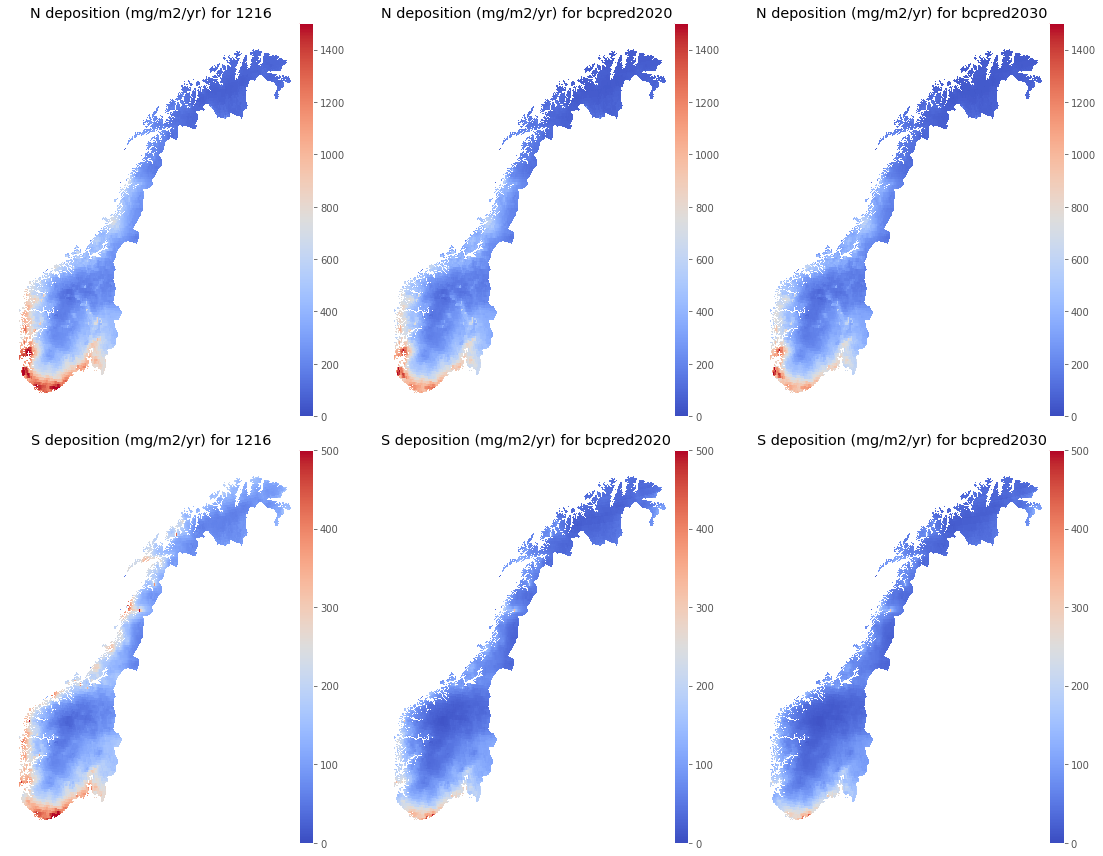

In [12]:
pars = ["n", "s"]
names = ["1216", "bcpred2020", "bcpred2030"]
vmax_dict = {
    "n": 1500,
    "s": 500,
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

for row_idx, par in enumerate(pars):
    for col_idx, name in enumerate(names):
        ras_path = f"/home/jovyan/shared/critical_loads/raster/deposition/{par}dep_mgpm2pyr_{name}_{cell_size}m.tif"
        with rasterio.open(ras_path) as src:
            divider = make_axes_locatable(axes[row_idx, col_idx])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = rasterio.plot.show(
                src,
                ax=axes[row_idx, col_idx],
                cmap="coolwarm",
                interpolation="none",
                vmin=0,
                vmax=vmax_dict[par],
            )
            fig.colorbar(im.images[0], cax=cax)
            axes[row_idx, col_idx].set_title(
                f"{par.upper()} deposition (mg/m2/yr) for {name}"
            )
            axes[row_idx, col_idx].axis("off")

plt.tight_layout()

### 3.2. Exceedance

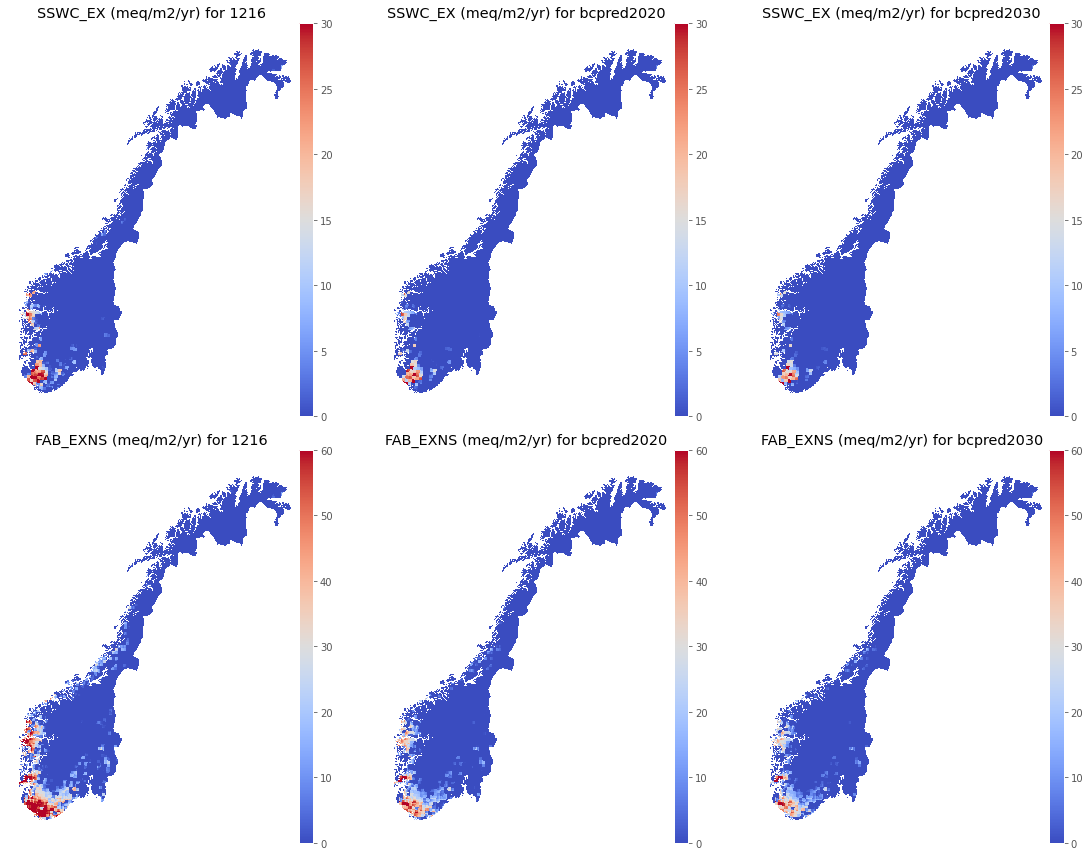

In [15]:
models = ["sswc_ex", "fab_exns"]
names = ["1216", "bcpred2020", "bcpred2030"]
vmax_dict = {
    "sswc_ex": 30,
    "fab_exns": 60,
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

for row_idx, model in enumerate(models):
    for col_idx, name in enumerate(names):
        ras_path = f"/home/jovyan/shared/critical_loads/raster/exceedance/{model}_meqpm2pyr_{name}_{cell_size}m.tif"
        with rasterio.open(ras_path) as src:
            divider = make_axes_locatable(axes[row_idx, col_idx])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = rasterio.plot.show(
                src,
                ax=axes[row_idx, col_idx],
                cmap="coolwarm",
                interpolation="none",
                vmin=0,
                vmax=vmax_dict[model],
            )
            fig.colorbar(im.images[0], cax=cax)
            axes[row_idx, col_idx].set_title(f"{model.upper()} (meq/m2/yr) for {name}")
            axes[row_idx, col_idx].axis("off")

plt.tight_layout()